In [1]:
# Import standard libraries
import pandas as pd
import numpy as np
import math
import bs4 as bs
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

# Import for text analytics
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import string
import gensim
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.utils import simple_preprocess
from gensim import corpora
import multiprocessing

# Import libraries for logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

# Load English language model of spacy
sp = spacy.load('en_core_web_sm')

# Text Analytics 2: Word Embedding

<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/0*QXJDYJTGexmpeQ43.jpg' width="450">

## Content

In this walkthrough, we pursue our exploration of [Text Analytics](https://en.wikipedia.org/wiki/Text_mining), diving into [Word Embedding](https://en.wikipedia.org/wiki/Word_embedding) and doing an application on sentiment classification.

- [Recap on text representation](#Recap-on-text-representation)
    - [Some definitions](#Some-definitions)
    - [Bag of Words (BOW)](#Bag-of-Words-(BOW))
    - [TF-IDF](#TF-IDF)
- [Introduction to Gensim and Word Embedding](#Introduction-to-Gensim-and-Word-Embedding)
    - [Background](#Background)
    - [Implementing Word2vec with Gensim](#Implementing-Word2vec-with-Gensim)
    - [Your turn](#Your-turn)
- [Application: Text Classification with TF-IDF vs Doc2Vec](#Application:-Text-Classification-with-TF-IDF-vs-Doc2Vec)
    - [Load and clean data](#Load-and-clean-data)
    - [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Classification using TF-IDF and Logistic Regression](#Classification-using-TF-IDF-and-Logistic-Regression)
    - [Classification using Doc2Vec and Logistic Regression](#Classification-using-Doc2Vec-and-Logistic-Regression)
    - [How to improve the accuracy of a text classifier?](#How-to-improve-the-accuracy-of-a-text-classifier?)
- [Further reading](#Further-reading)

## Recap on text representation

In order to be able to use texts as inputs for classification, we have to transform them into numbers (i.e., vectors). There are several ways of doing this. We recap in this section the concepts and techniques seen last week, namely Bag of Words and TF-IDF.

### Some definitions

- Document = some text, i.e., a string (e.g., a sentence, a tweet, paragraph of text, book, news article, etc.).
- Corpus = collection of documents.
- Dictionary = list of unique tokens in (preprocessed) corpus.
- Vector = mathematical representation of a document (e.g., Bag of Words).
- Model = algorithm used for transforming vectors from one representation to another (e.g., TF-IDF).

Let's illustrate these concepts in Python, using text from the article *[The decarbonisation of Europe powered by lifestyle changes](https://iopscience.iop.org/article/10.1088/1748-9326/abe890/meta)*.

Reference: Costa, L., Moreau, V., et al. (2021). The decarbonisation of Europe powered by lifestyle changes. *Environmental Research Letters*, 16(4), 044057.

Recall that you can define a string using single quotes, double quotes, or triple quotes:

In [2]:
# A document
doc = 'Changes in behaviour may contribute more than 20% of the GHG emission reductions required for net-zero.' 
doc = "Changes in behaviour may contribute more than 20% of the GHG emission reductions required for net-zero." 
doc = """Changes in behaviour may contribute more than 20% of the GHG emission reductions required for net-zero.""" 

Here is a corpus, containing a collection of sentences:

In [3]:
# A corpus
d1 = "The impacts of behavioural change vary across sectors."
d2 = "Changes in travel behaviour limit the rising demand for electricity."
d3 = "Adopting a healthy diet reduces emissions substantially."
d4 = "Without behavioural change, the dependency of Europe on carbon removal technologies increases."
d5 = "Changes in lifestyles are crucial, contributing to achieving climate targets sooner."
corpus = [d1, d2, d3, d4, d5]
corpus

['The impacts of behavioural change vary across sectors.',
 'Changes in travel behaviour limit the rising demand for electricity.',
 'Adopting a healthy diet reduces emissions substantially.',
 'Without behavioural change, the dependency of Europe on carbon removal technologies increases.',
 'Changes in lifestyles are crucial, contributing to achieving climate targets sooner.']

Let's create a dictionary for our corpus. First, we apply a simple preprocessing technique to convert each each sentence into a list of tokens (words). We are using the [Gensim](https://pypi.org/project/gensim/) library.

In [4]:
# Preprocessing
processed_corpus = [simple_preprocess(d) for d in corpus]
print(processed_corpus)

[['the', 'impacts', 'of', 'behavioural', 'change', 'vary', 'across', 'sectors'], ['changes', 'in', 'travel', 'behaviour', 'limit', 'the', 'rising', 'demand', 'for', 'electricity'], ['adopting', 'healthy', 'diet', 'reduces', 'emissions', 'substantially'], ['without', 'behavioural', 'change', 'the', 'dependency', 'of', 'europe', 'on', 'carbon', 'removal', 'technologies', 'increases'], ['changes', 'in', 'lifestyles', 'are', 'crucial', 'contributing', 'to', 'achieving', 'climate', 'targets', 'sooner']]


We now create our dictionary, obtaining a mapping between each word in our corpus and an associated integer identification:

In [5]:
# A dictionary
dictionary = corpora.Dictionary(processed_corpus)
print(dictionary)

Dictionary<40 unique tokens: ['across', 'behavioural', 'change', 'impacts', 'of']...>


In [6]:
print(dictionary.token2id)

{'across': 0, 'behavioural': 1, 'change': 2, 'impacts': 3, 'of': 4, 'sectors': 5, 'the': 6, 'vary': 7, 'behaviour': 8, 'changes': 9, 'demand': 10, 'electricity': 11, 'for': 12, 'in': 13, 'limit': 14, 'rising': 15, 'travel': 16, 'adopting': 17, 'diet': 18, 'emissions': 19, 'healthy': 20, 'reduces': 21, 'substantially': 22, 'carbon': 23, 'dependency': 24, 'europe': 25, 'increases': 26, 'on': 27, 'removal': 28, 'technologies': 29, 'without': 30, 'achieving': 31, 'are': 32, 'climate': 33, 'contributing': 34, 'crucial': 35, 'lifestyles': 36, 'sooner': 37, 'targets': 38, 'to': 39}


### Bag of Words (BOW)

**Bag of Words (BOW)** is the simplest approach to achieve the transformation of documents into vectors. It is divided into two basic steps:
- Create a dictionary of unique words from the corpus.
- Analyse the documents, i.e. for each word in the dictionary and each document, add 1 if the word is in the document, otherwise 0.

Let's implement BOW from scratch using the [spaCy](https://spacy.io/) library. We first define two functions: the first one to get the words of a document and the second to get the unique words of a corpus of documents.

In [7]:
# Tokens in document
def get_tokens(document):
    doc_tokens = ([token.lower_ for token in sp(document) 
                   if (token.is_punct == False) and (token.is_space == False)])
    return doc_tokens

In [8]:
get_tokens(d1)

['the', 'impacts', 'of', 'behavioural', 'change', 'vary', 'across', 'sectors']

In [9]:
# List of unique words in corpus (dictionary)
def vocabulary(corpus):
    # Delare output
    word_list = []
    # Loop documents - lower each word and add it to the output
    for document in corpus:
        spacy_doc = sp(document)
        for token in spacy_doc:
            if token.lower_ not in word_list and (token.is_punct == False) and (token.is_space == False):
                word_list.append(token.lower_)
    # Return output
    return word_list

In [10]:
print(vocabulary(corpus))

['the', 'impacts', 'of', 'behavioural', 'change', 'vary', 'across', 'sectors', 'changes', 'in', 'travel', 'behaviour', 'limit', 'rising', 'demand', 'for', 'electricity', 'adopting', 'a', 'healthy', 'diet', 'reduces', 'emissions', 'substantially', 'without', 'dependency', 'europe', 'on', 'carbon', 'removal', 'technologies', 'increases', 'lifestyles', 'are', 'crucial', 'contributing', 'to', 'achieving', 'climate', 'targets', 'sooner']


We use our two functions to create the Bag of Words. 

In [11]:
# Bag of Words
def bow(document, corpus):
    # Get tokens
    doc_tokens = get_tokens(document)
    corpus_tokens = vocabulary(corpus)
    # Initialization
    bag = {}
    for token in corpus_tokens:
        bag[token] = 0
    # Add 1 if token is in document
    for token in doc_tokens:
        bag[token] += 1
    # Return
    return bag

Here is what we obtain for the first sentence of our corpus:

In [12]:
print(bow(d1, corpus))

{'the': 1, 'impacts': 1, 'of': 1, 'behavioural': 1, 'change': 1, 'vary': 1, 'across': 1, 'sectors': 1, 'changes': 0, 'in': 0, 'travel': 0, 'behaviour': 0, 'limit': 0, 'rising': 0, 'demand': 0, 'for': 0, 'electricity': 0, 'adopting': 0, 'a': 0, 'healthy': 0, 'diet': 0, 'reduces': 0, 'emissions': 0, 'substantially': 0, 'without': 0, 'dependency': 0, 'europe': 0, 'on': 0, 'carbon': 0, 'removal': 0, 'technologies': 0, 'increases': 0, 'lifestyles': 0, 'are': 0, 'crucial': 0, 'contributing': 0, 'to': 0, 'achieving': 0, 'climate': 0, 'targets': 0, 'sooner': 0}


Let's do the same for all our documents and visualize the result in a dataframe:

In [13]:
# BOW for all documents in corpus
bag_of_words = [bow(d, corpus) for d in corpus]

# Visualize in dataframe
pd.set_option("display.max_columns", None)
pd.DataFrame(bag_of_words,
    index= ['d1', 'd2', 'd3', 'd4', 'd5']
    )

,the,impacts,of,behavioural,change,vary,across,sectors,changes,in,travel,behaviour,limit,rising,demand,for,electricity,adopting,a,healthy,diet,reduces,emissions,substantially,without,dependency,europe,on,carbon,removal,technologies,increases,lifestyles,are,crucial,contributing,to,achieving,climate,targets,sooner
d1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d2,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
d4,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0
d5,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1


Note that this is not perfect. We could (should) remove stopwords, use lemmatization, and potentially consider n-grams.

Instead of implementing the technique from scratch, we can rely on the `CountVectorizer` class of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)):

In [14]:
# Initialize model
vectorizer = CountVectorizer()

# Learn the vocabulary dictionary and return document-term matrix
bag_of_words = vectorizer.fit_transform(corpus).todense()

# DataFrame
bag_of_words = pd.DataFrame(bag_of_words, 
                            columns=vectorizer.get_feature_names_out(),
                            index = ['d1', 'd2', 'd3', 'd4', 'd5'])
bag_of_words

,achieving,across,adopting,are,behaviour,behavioural,carbon,change,changes,climate,contributing,crucial,demand,dependency,diet,electricity,emissions,europe,for,healthy,impacts,in,increases,lifestyles,limit,of,on,reduces,removal,rising,sectors,sooner,substantially,targets,technologies,the,to,travel,vary,without
d1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
d2,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
d3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0
d4,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,0,1
d5,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0


Advantages of BOW:
- No need of huge corpus of words to get good results in practice.
- Easy to understand (i.e., not mathematically complex).

Disadvantages of BOW:
- A lot of zeros (imagine a corpus of 1000 articles) --> consume memory and space.
- Does not maintain any context information ("I eat a fish" vs. "A fish eats me").
- Half solutions: n-grams, specifiying min_df and max_df (see [documentation](https://https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

### TF-IDF

**TF-IDF** is a type of bag of words approach where instead of adding zeros and ones in the embedding vector, we add floating numbers that contain more useful information. The idea is to emphasize words that appear in few documents in the corpus. A word that appear many times but only in one document will have a high value (close to one) compared to words that appear many times in many documents. This word is then very useful to identify the document.

TF-IDF is the product of term frequency (TF) and inverse document frequency (IDF):
- **Term Frequency** identifies tokens that appear frequently in a document: 
    - TF(token, document) = number of times token appears in document / total number of tokens in document
    - greater if word appears many times in document
- **Inverse Document Frequency** identifies words that appear rarely in the corpus: 
    - IDF(token, corpus) = log( total number of documents in corpus / number of documents containing token )
    - greater if word appears in fewer doucuments
    
Ok, let's try implement from scratch TF-IDF! First, we define a function to compute the term frequency:

In [15]:
# Term frequency (TF)
def tf(document):
    # Get tokens
    tokens = get_tokens(document)
    # Initialization 
    term_freq = {token: 0 for token in tokens}  # Notice the use of comprehension!
    # Increment
    for token in tokens:
        term_freq[token] += 1/len(tokens)
    # Return
    return term_freq

Let's check our function:

In [16]:
tf(d1)

{'the': 0.125,
 'impacts': 0.125,
 'of': 0.125,
 'behavioural': 0.125,
 'change': 0.125,
 'vary': 0.125,
 'across': 0.125,
 'sectors': 0.125}

Each words appear once in our sentence, and the sentence contains 8 words. Hence, the frequency of each token is 1/8=0.125.

Let's proceed, defining a function to compute the inverse document frequency:

In [17]:
# Inverse document frequency
def idf(corpus):
    # Get list of unique words in corpus
    voc = vocabulary(corpus)
    # Initialization
    inv_doc_freq = {word: 0 for word in voc}
    # Number of apparition of word
    for word in voc:
        for document in corpus:
            doc_tokens = get_tokens(document)
            if word in doc_tokens:
                inv_doc_freq[word] += 1
    # IDF
    inv_doc_freq = {k: math.log(len(corpus) / inv_doc_freq[k]) for k in inv_doc_freq.keys()}
    # Return
    return inv_doc_freq

Let's test our function:

In [18]:
idf(corpus)

{'the': 0.5108256237659907,
 'impacts': 1.6094379124341003,
 'of': 0.9162907318741551,
 'behavioural': 0.9162907318741551,
 'change': 0.9162907318741551,
 'vary': 1.6094379124341003,
 'across': 1.6094379124341003,
 'sectors': 1.6094379124341003,
 'changes': 0.9162907318741551,
 'in': 0.9162907318741551,
 'travel': 1.6094379124341003,
 'behaviour': 1.6094379124341003,
 'limit': 1.6094379124341003,
 'rising': 1.6094379124341003,
 'demand': 1.6094379124341003,
 'for': 1.6094379124341003,
 'electricity': 1.6094379124341003,
 'adopting': 1.6094379124341003,
 'a': 1.6094379124341003,
 'healthy': 1.6094379124341003,
 'diet': 1.6094379124341003,
 'reduces': 1.6094379124341003,
 'emissions': 1.6094379124341003,
 'substantially': 1.6094379124341003,
 'without': 1.6094379124341003,
 'dependency': 1.6094379124341003,
 'europe': 1.6094379124341003,
 'on': 1.6094379124341003,
 'carbon': 1.6094379124341003,
 'removal': 1.6094379124341003,
 'technologies': 1.6094379124341003,
 'increases': 1.609437912

Ok, finally we compute TF-IDF!

In [19]:
# TF-IDF
def tfidf(document, corpus):
    # TF
    tf_bag = tf(document)
    # IDF
    idf_bag = idf(corpus)
    # TF*IDF
    tfidf_bag = {k: tf_bag[k]*idf_bag[k] for k in tf_bag.keys()}
    return tfidf_bag

Let's see the result for the first sentence of our corpus:

In [20]:
tfidf(d1, corpus)

{'the': 0.06385320297074884,
 'impacts': 0.20117973905426254,
 'of': 0.11453634148426939,
 'behavioural': 0.11453634148426939,
 'change': 0.11453634148426939,
 'vary': 0.20117973905426254,
 'across': 0.20117973905426254,
 'sectors': 0.20117973905426254}

Compared to what we obtained with TF, the tokens are now scaled by the IDF. For instance, since "the" is a common word, its TF-IDF is lower than words like "sectors" that appears only once in our corpus.

Let's compute TF-IDF for all tokens and documents and visualize the result in a dataframe.

In [21]:
# TF-IDF for all documents
bag_of_words_tfidf = [tfidf(doc, corpus) for doc in corpus]

# Visualize in Dataframe
pd.DataFrame(bag_of_words_tfidf,
    index= ['d1', 'd2', 'd3', 'd4', 'd5']
    ).fillna(0)

,the,impacts,of,behavioural,change,vary,across,sectors,changes,in,travel,behaviour,limit,rising,demand,for,electricity,adopting,a,healthy,diet,reduces,emissions,substantially,without,dependency,europe,on,carbon,removal,technologies,increases,lifestyles,are,crucial,contributing,to,achieving,climate,targets,sooner
d1,0.063853,0.20118,0.114536,0.114536,0.114536,0.20118,0.20118,0.20118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d2,0.051083,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.091629,0.091629,0.160944,0.160944,0.160944,0.160944,0.160944,0.160944,0.160944,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d3,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.22992,0.22992,0.22992,0.22992,0.22992,0.22992,0.22992,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d4,0.042569,0.00000,0.076358,0.076358,0.076358,0.00000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13412,0.13412,0.13412,0.13412,0.13412,0.13412,0.13412,0.13412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d5,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.083299,0.083299,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.146313,0.146313,0.146313,0.146313,0.146313,0.146313,0.146313,0.146313,0.146313


As before with BOW, the result is not perfect since we could remove stopwords, and use n-gramms and lemmas.

Instead of implementing the technique from scracth, we can use the `TfidfVectorizer` class of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)). Note that the results differ from ours because `TfidfVectorizer` is using a slightly different formula to compute IDF.

In [22]:
# Initialize model
vectorizer = TfidfVectorizer()

# Learn the vocabulary dictionary and return document-term matrix
bag_of_words_tfidf = vectorizer.fit_transform(corpus).todense()

# DataFrame
bag_of_words_tfidf = pd.DataFrame(bag_of_words_tfidf, 
                                  columns=vectorizer.get_feature_names_out(),
                                  index = ['d1', 'd2', 'd3', 'd4', 'd5'])
bag_of_words_tfidf

,achieving,across,adopting,are,behaviour,behavioural,carbon,change,changes,climate,contributing,crucial,demand,dependency,diet,electricity,emissions,europe,for,healthy,impacts,in,increases,lifestyles,limit,of,on,reduces,removal,rising,sectors,sooner,substantially,targets,technologies,the,to,travel,vary,without
d1,0.000000,0.395246,0.000000,0.000000,0.000000,0.318882,0.000000,0.318882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.395246,0.000000,0.000000,0.000000,0.000000,0.318882,0.000000,0.000000,0.000000,0.000000,0.395246,0.000000,0.000000,0.000000,0.000000,0.264701,0.000000,0.000000,0.395246,0.000000
d2,0.000000,0.000000,0.000000,0.000000,0.338055,0.000000,0.000000,0.000000,0.272741,0.000000,0.000000,0.000000,0.338055,0.000000,0.000000,0.338055,0.000000,0.000000,0.338055,0.000000,0.000000,0.272741,0.000000,0.000000,0.338055,0.000000,0.000000,0.000000,0.000000,0.338055,0.000000,0.000000,0.000000,0.000000,0.000000,0.226399,0.000000,0.338055,0.000000,0.000000
d3,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.408248,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.408248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
d4,0.000000,0.000000,0.000000,0.000000,0.000000,0.250161,0.310068,0.250161,0.000000,0.000000,0.000000,0.000000,0.000000,0.310068,0.000000,0.000000,0.000000,0.310068,0.000000,0.000000,0.000000,0.000000,0.310068,0.000000,0.000000,0.250161,0.310068,0.000000,0.310068,0.000000,0.000000,0.000000,0.000000,0.000000,0.310068,0.207656,0.000000,0.000000,0.000000,0.310068
d5,0.311561,0.000000,0.000000,0.311561,0.000000,0.000000,0.000000,0.000000,0.251365,0.311561,0.311561,0.311561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.251365,0.000000,0.311561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.311561,0.000000,0.311561,0.000000,0.000000,0.311561,0.000000,0.000000,0.000000


Advantage of TF-IDF:
- Smart way of representing documents in corpus. More information is provided.

Disadvantages of TF-IDF (same as for BOW):
- A lot of zeros (imagine a corpus of 1000 articles) --> consume memory and space
- Does not maintain any context information ("I eat a fish" vs. "A fish eats me")
- Half solutions: n-grams, specifiying min_df and max_df (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)).

## Introduction to Gensim and Word Embedding

With BOW and TF-IDF, similar sentences/words have a completely different representation. Thus, sentences with different words but same meaning/semantics will be very distant.

In the following, we illustrate how we can find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

We will use the [Gensim](https://pypi.org/project/gensim/) library. Gensim stands for "Generate Similar". It is a popular open-source natural language processing (NLP) library used for unsupervised topic modeling. A complete tutorial can be found [here](https://www.tutorialspoint.com/gensim/gensim_introduction.htm). 

### Background

Word embedding approaches use deep learning and neural network-based techniques to convert words into corresponding vectors so that semantically similar vectors are close to each other in an N-dimensional space, where N refers to the dimensions of the vectors. The underlying assumption is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model.

Two word embedding methods:
- [Word2vec](https://en.wikipedia.org/wiki/Word2vec), by Google
- [GloVe](https://en.wikipedia.org/wiki/GloVe) (Global vectors for Word Representation), by Stanford

Word2vec gives astonishing results. Its ability to maintain a semantic relationship is reflected in a classic example where if you have a vector for the word "King" and you remove the vector represented by the word "Man" from the "King" and add "Woman", you get a vector that is close to the vector "Queen": 
- King - Man + Woman = Queen

Second example: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2vec they will therefore share a similar vector representation.

In real applications, Word2vec models are created from billions of documents. For example, [Google's Word2Vec model](https://code.google.com/archive/p/word2vec/) is formed from 3 million words and phrases.

GloVe is an extension of Word2vec. More information [here](https://nlp.stanford.edu/projects/glove/).

Recently, more advanced models have been developed, such as [BERT](https://en.wikipedia.org/wiki/BERT_(language_model)) - Bidirectional Encoder Representations from Transformers-  and [GPT-3](https://en.wikipedia.org/wiki/GPT-3) - Generative Pre-trained Transformer 3. While Word2vec models represent tokens (word) with a single vector, BERT generates different output vectors for a same word when used in different context. You can find further readings on the topic at the end of this notebook.

### Implementing Word2vec with Gensim

We will implement Word2vec using the Gensim library. We are going to use a corpus of text extracted from Wikipedia by web scrapping. We first define a function to retrieve texts from a Wikipedia url:

In [23]:
# Get texts from Wikipedia
def get_text(url):
    # Retrieve data
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    # Parse data: # The text is contained in the HTML tag 'p'
    parsed_article = bs.BeautifulSoup(article,'lxml')
    paragraphs = parsed_article.find_all('p')  
    # Create a string with all the paragraphs
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

Let's get the Wikipedia articles on [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning) and on [Artificial Intelligence](https://en.wikipedia.org/wiki/Artificial_intelligence). This will be our corpus of documents.

In [24]:
# Get articles
machine_learning = get_text("https://en.wikipedia.org/wiki/Machine_learning")
ai = get_text("https://en.wikipedia.org/wiki/Artificial_intelligence")

print(machine_learning[:705])
print(ai[:741])

# Group texts in list
texts = [machine_learning, ai]

Machine learning (ML) is a field devoted to understanding and building methods that let machines "learn" – that is, methods that leverage data to improve computer performance on some set of tasks.[1] It is seen as a broad subfield of artificial intelligence[2]. 
Machine learning algorithms build a model based on sample data, known as training data, in order to make predictions or decisions without being explicitly programmed to do so.[3] Machine learning algorithms are used in a wide variety of applications, such as in medicine, email filtering, speech recognition, agriculture, and computer vision, where it is difficult or unfeasible to develop conventional algorithms to perform the needed tasks.

Artificial intelligence (AI) is intelligence—perceiving, synthesizing, and inferring information—demonstrated by machines, as opposed to intelligence displayed by non-human animals or by humans. Example tasks in which this is done include speech recognition, computer vision, translation betwe

Next, we preprocess out texts. We create a tokenizer function to lemmatize each token and remove stopwords.

In [25]:
# Create tokenizer function for preprocessing
def spacy_tokenizer(text):

    # Define stopwords, punctuation, and numbers
    stop_words = spacy.lang.en.stop_words.STOP_WORDS
    punctuations = string.punctuation +'–' + '—'
    numbers = "0123456789"

    # Create spacy object
    mytokens = sp(text)

    # Lemmatize each token and convert each token into lowercase
    mytokens = ([ word.lemma_.lower().strip() for word in mytokens ])

    # Remove stop words and punctuation
    mytokens = ([ word for word in mytokens 
                 if word not in stop_words and word not in punctuations ])

    # Remove sufix like ".[1" in "experience.[1"
    mytokens_2 = []
    for word in mytokens:
        for char in word:
            if (char in punctuations) or (char in numbers):
                word = word.replace(char, "")
        if word != "":
            mytokens_2.append(word)

    # Return preprocessed list of tokens
    return mytokens_2

Let's apply our function to tokenize our corpus of documents:

In [26]:
# Tokenize texts
processed_texts = [spacy_tokenizer(text) for text in texts]

for processed_text in processed_texts:
    print(processed_text[:20])

['machine', 'learning', 'ml', 'field', 'devote', 'understanding', 'building', 'method', 'let', 'machine', 'learn', 'method', 'leverage', 'datum', 'improve', 'computer', 'performance', 'set', 'tasks', 'broad']
['artificial', 'intelligence', 'ai', 'intelligence', 'perceive', 'synthesize', 'infer', 'information', 'demonstrate', 'machine', 'oppose', 'intelligence', 'display', 'non', 'human', 'animal', 'human', 'example', 'task', 'include']


Now that our text is preprocessed, we can train a Word2vec model. We use the `Word2Vec` module of Gensim ([Documentation](https://radimrehurek.com/gensim/models/word2vec.html)). As input, we provide the processed texts, i.e., a list of lists of tokens. In addition, we use as parameters:
- `min_count`: minimum number of occurence of single word in corpus to be taken into account
- `vector_size`: dimension of the vectors representing the tokens

Once the model is trained, we can access to the mapping between words and embeddings with the method `.wv`

In [27]:
# Word embedding 
word2vec = Word2Vec(processed_texts, min_count=2, vector_size=100)

# Vocabulary
vocab = word2vec.wv.key_to_index
print(vocab)

{'learning': 0, 'machine': 1, 'ai': 2, 'use': 3, 'learn': 4, 'datum': 5, 'algorithm': 6, 'intelligence': 7, 'model': 8, 'artificial': 9, 'system': 10, 'problem': 11, 'human': 12, 'example': 13, 'network': 14, 'include': 15, 'training': 16, 'field': 17, 'computer': 18, 'input': 19, 'method': 20, 'neural': 21, 'set': 22, 'research': 23, 'knowledge': 24, 'approach': 25, 'program': 26, 'decision': 27, 'task': 28, 'logic': 29, 'base': 30, 'search': 31, 'know': 32, 'application': 33, 'train': 34, 'feature': 35, 'represent': 36, 'technique': 37, 'classification': 38, 'theory': 39, 'solve': 40, 'goal': 41, 'process': 42, 'term': 43, 'researcher': 44, 'function': 45, 'bias': 46, 'develop': 47, 'symbolic': 48, 'neuron': 49, 'rule': 50, 'time': 51, 'perform': 52, 'find': 53, 'optimization': 54, 'specific': 55, 'general': 56, 'consider': 57, 'layer': 58, 'increase': 59, 'representation': 60, 'information': 61, 'deep': 62, 'tool': 63, 'mathematical': 64, 'reasoning': 65, 'form': 66, 'output': 67, '

Each token (word) is represented by a vector (array) of size 100:

In [28]:
# Vector
v1 = word2vec.wv['intelligence'] 
v1

array([-0.01124301,  0.02716064,  0.02493959,  0.0161529 , -0.00151713,
       -0.05164349,  0.03738473,  0.07211006, -0.03325435, -0.01470454,
       -0.018749  , -0.04682782, -0.00137586,  0.00723688,  0.00967483,
       -0.0169712 ,  0.0061463 , -0.0292648 , -0.02087592, -0.08004323,
        0.02208753,  0.02545436,  0.02187319, -0.02586406, -0.02569048,
        0.00487537, -0.03035493, -0.0346113 , -0.03428375,  0.01071933,
        0.03900285,  0.00765329,  0.03339196, -0.02608952, -0.01705804,
        0.05124933,  0.00065832, -0.03572699, -0.04369202, -0.06078159,
        0.02213956, -0.03786856, -0.01375635, -0.00246338,  0.03464214,
       -0.01880604, -0.03677132,  0.00467275,  0.03742966,  0.0167763 ,
        0.00290746, -0.0338918 ,  0.0140862 , -0.00047092, -0.02395891,
        0.041545  ,  0.01075117, -0.0136485 , -0.03188495,  0.01054012,
        0.01337547,  0.00603084, -0.01041854, -0.00974845, -0.04735749,
        0.03484292, -0.00313595,  0.03756853, -0.06233218,  0.03

In this space, we can explore the similarities between tokens. For instance, let's find the most similar words to "intelligence":

In [29]:
# Similar vectors/words
sim_words = word2vec.wv.most_similar('intelligence')
sim_words

[('ai', 0.9684892296791077),
 ('learning', 0.9665432572364807),
 ('system', 0.9627737998962402),
 ('problem', 0.9623109698295593),
 ('human', 0.9587778449058533),
 ('use', 0.958672285079956),
 ('machine', 0.9563555717468262),
 ('input', 0.9553102254867554),
 ('algorithm', 0.9533578157424927),
 ('learn', 0.9532964825630188)]

Or the similarity between two words:

In [30]:
# Similarity between two words
print('The similarity between "computer" and "animal" is: ', word2vec.wv.similarity('computer', 'animal'))
print('The similarity between "computer" and "machine" is: ', word2vec.wv.similarity('computer', 'machine'))

The similarity between "computer" and "animal" is:  0.5379945
The similarity between "computer" and "machine" is:  0.9407522


Remarks:
- There are other models than Word2Vec in Gensim. For instance, `Doc2Vec` is used to create a vectorised representation of a group of words (i.e., a document) taken collectively as a single unit (illustrated in the next section).
- Gensim has many applications besides word embedding, see e.g., [topic modelling](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/). Feel free to explore the library!

### Your turn

- Using the functions defined above, create a corpus of documents with the following Wikipedia articles: [Photovoltaics](https://en.wikipedia.org/wiki/Photovoltaics), [Wind turbine](https://en.wikipedia.org/wiki/Wind_turbine), [Hydropower](https://en.wikipedia.org/wiki/Hydropower), and [Nuclear power plant](https://en.wikipedia.org/wiki/Nuclear_power_plant). Do you know the share of each technology in the Swiss electricity mix? Check the [Electricity sector in Switzerland](https://en.wikipedia.org/wiki/Electricity_sector_in_Switzerland) for the answer...

In [31]:
# YOUR CODE HERE


- Preprocessing: Tokenize your corpus of documents

In [32]:
# YOUR CODE HERE


- What is the number of occurrences of the word "energy"?

In [33]:
# YOUR CODE HERE


- Create a Word2Vec representation of the article with a min_count of 1 and a vector size of 50

In [34]:
# YOUR CODE HERE


- What are the 10 most similar words to "electricity"?

In [35]:
# YOUR CODE HERE


## Application: Text Classification with TF-IDF vs Doc2Vec

In this section, we do an application on text classification to illustrate how the embedding can influence the accuracy of a classifier. 

Our goal is to classify consumer finance complaints into 12 pre-defined categories using:
- TF-IDF and logistic regression
- Doc2Vec and logistic regression
We use the same tokenizer function, train-test split, classification algorithm, etc. The only difference is the mathematical representation (i.e., the vectorization from the tokens) of the complaints.

This application was inspired by the articles published by Susan Li on Towards Data Science:
- [Multi-Class Text Classification with Scikit-Learn](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f)
- [Multi-Class Text Classification with Doc2Vec & Logistic Regression](https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4)

### Load and clean data

We work with a sample of a large dataset from Data.gov that can be found [here](https://catalog.data.gov/dataset/consumer-complaint-database).

In [36]:
# Load data from GitHub
path = "https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/complaints_sample.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2012-12-24,Credit card,NaN,Rewards,NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",IL,60611,NaN,NaN,Web,2012-12-24,Closed with explanation,Yes,No,217083
1,2013-12-17,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,REGIONS FINANCIAL CORPORATION,FL,33415,NaN,NaN,Web,2013-12-17,Closed with explanation,Yes,Yes,636638
2,2018-04-23,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,TX,77386,NaN,NaN,Fax,2018-04-23,Closed with explanation,Yes,NaN,2883487
3,2019-01-04,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,NaN,NaN,HSBC NORTH AMERICA HOLDINGS INC.,AZ,94521,NaN,NaN,Referral,2019-01-08,Closed with explanation,Yes,NaN,3118526
4,2014-07-22,Debt collection,Payday loan,Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"ENOVA INTERNATIONAL, INC.",GA,30038,NaN,NaN,Web,2014-07-22,Closed with explanation,Yes,No,948293


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9101 entries, 0 to 9100
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 9101 non-null   object
 1   Product                       9101 non-null   object
 2   Sub-product                   7942 non-null   object
 3   Issue                         9101 non-null   object
 4   Sub-issue                     6251 non-null   object
 5   Consumer complaint narrative  3137 non-null   object
 6   Company public response       3863 non-null   object
 7   Company                       9101 non-null   object
 8   State                         8946 non-null   object
 9   ZIP code                      8199 non-null   object
 10  Tags                          1171 non-null   object
 11  Consumer consent provided?    5869 non-null   object
 12  Submitted via                 9101 non-null   object
 13  Date sent to compa

The data set includes 18 columns and 9101 rows describing consumer complaints about financial products. In this case, we want to predict the `Product` category based on the text of the complaint (i.e., `Consumer complaint narrative`).

In [38]:
# Select columns of interest
data = df[["Product", "Consumer complaint narrative"]]

Around 2/3 of the complaints are null values. They are not useful for the prediction so we drop them.

In [39]:
# Drop NaN
print(data.isnull().sum())
data = data.dropna().reset_index(drop=True)
data.head()

Product                            0
Consumer complaint narrative    5964
dtype: int64


,Product,Consumer complaint narrative
0,Credit card or prepaid card,Back in XX/XX/2019 a company called XXXX charg...
1,"Credit reporting, credit repair services, or o...",XXXX is reporting a single late payment over 7...
2,"Credit reporting, credit repair services, or o...","I have disputed the following account, ( 1 ) X..."
3,"Credit reporting, credit repair services, or o...",In XX/XX/XXXXI disputed the following items on...
4,Credit card or prepaid card,The response from Citi Cards has cleared up a ...


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Product                       3137 non-null   object
 1   Consumer complaint narrative  3137 non-null   object
dtypes: object(2)
memory usage: 49.1+ KB


We end up with 3137 complaints for which we would like to predict the product concerned.

### Exploratory Data Analysis

As always, we start by an EDA to better understand our data and inform our analysis. First note that we are dealing with a dataset containing a large number of words: 

In [41]:
# Total number of words - over 600,000
words_number = data['Consumer complaint narrative'].apply(lambda x: len(x.split(' '))).sum()
print(f'The complaints contain {words_number} words.')

The complaints contain 610062 words.


Let's extract a sample to see how the complaints look like:

In [42]:
# Sample
data['Consumer complaint narrative'].sample().values[0]

"I have not had XXXX XXXX XXXX as a service since 2009 and when i left them i paid off my account and contract with nothing owed. Today i have a new collection on my report from a collection company that bought the debt from XXXX XXXX XXXX. I've tried to communicate with them and the credit bureaus that this debt is not mine but have not gotten any results. Please help as it is affecting my ability to get the best home interest rates."

The data has been anonymized (i.e., names, dates, IDs, etc. have been replaced by XXXX).

Next, note that the classes (products) are imbalanced:

In [43]:
# Imbalanced dataset
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1123
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      211
Credit reporting                                                                 167
Student loan                                                                     129
Checking or savings account                                                      119
Credit card                                                                       74
Money transfer, virtual currency, or money service                                64
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                        

There are 17 categories. We group some of them together (e.g. "Credit card", "Prepaid card", and "Credit or prepaid card") because they are sub-categories of each other. We end up with 12 categories.

In [44]:
# Merge categories
dic_replace = {'Credit reporting':'Credit reporting, credit repair services, or other personal consumer reports', 
               'Credit card':'Credit card or prepaid card', 
               'Payday loan':'Payday loan, title loan, or personal loan', 
               'Money transfers':'Money transfer, virtual currency, or money service',
               'Prepaid card':'Credit card or prepaid card',
               'Virtual currency':'Money transfer, virtual currency, or money service'}
data.replace(dic_replace, inplace=True)
data.Product.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    1290
Debt collection                                                                  640
Mortgage                                                                         378
Credit card or prepaid card                                                      291
Student loan                                                                     129
Checking or savings account                                                      119
Money transfer, virtual currency, or money service                                72
Bank account or service                                                           64
Vehicle loan or lease                                                             57
Payday loan, title loan, or personal loan                                         55
Consumer Loan                                                                     38
Other financial service                                          

Let's visualize the number of observation per product using a bar plot.

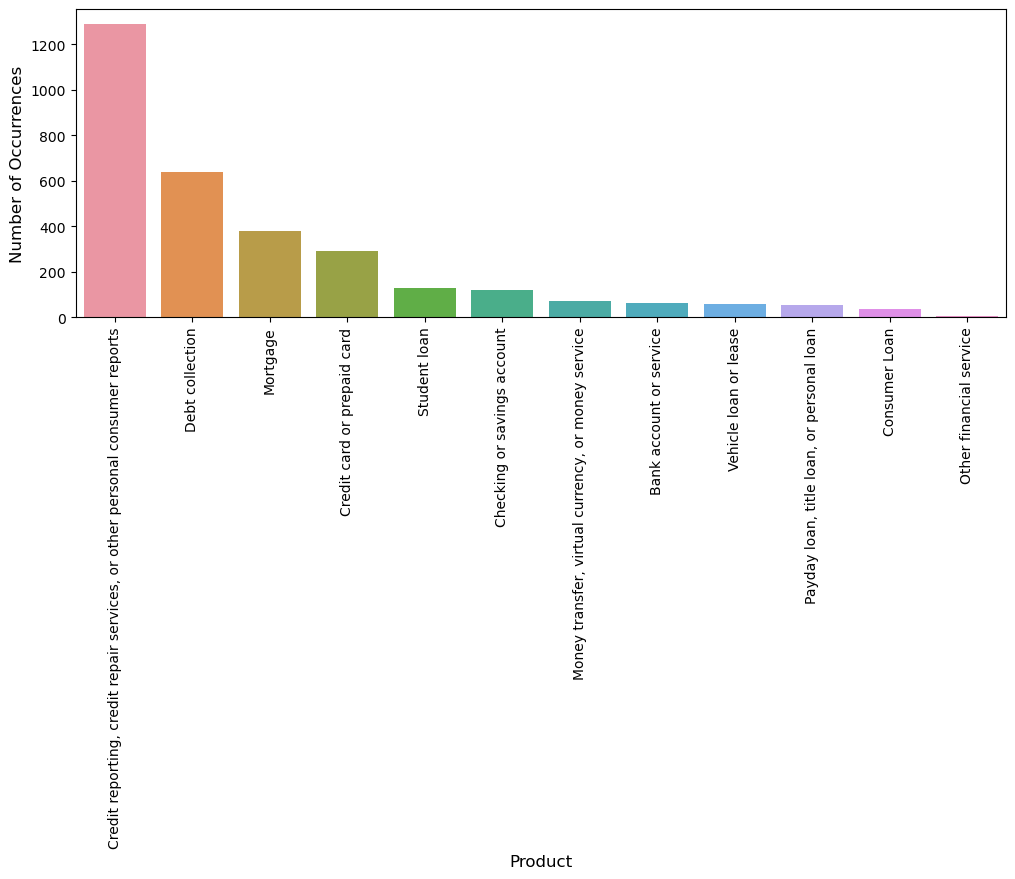

In [45]:
# Plot number of complaints per category
cnt_pro = data['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.countplot(x=data['Product'], order = cnt_pro.index)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)
plt.show()

Finally, let's compute the base rate, i.e., the accuracy obtained using a naive classifier that predicts that all observations are from the largest class ("Credit reporting, credit repair services, or other personal consumer reports").

In [46]:
# Base rate
base_rate = round(len(data[data.Product == "Credit reporting, credit repair services, or other personal consumer reports"]) / len (data), 4)
print(f'The base rate is: {base_rate*100:0.2f}%')

The base rate is: 41.12%


### Classification using TF-IDF and Logistic Regression

We first define our training and test set, using the `train_test_split` module of sklearn.

In [47]:
# Select features
X = data['Consumer complaint narrative'] # Features we want to analyze
ylabels = data['Product']                # Labels we test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234)

Next, we use the `TfidfVectorizer` class of sklearn for the word embedding. Since we are dealing with very specific data (e.g., the anonymization process generated non-standard sequence of characters), we are defining our own tokenizer function, which we can use as parameter of `TfidfVectorizer` instead of the default one.

In [48]:
# Define tokenizer function
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.en.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Remove anonymous dates and people
    mytokens = [ word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in ["xxxx", "xx", ""] ]

    # Return preprocessed list of tokens
    return mytokens

As other parameters of `TfidfVectorizer`, we are using token and pair of tokens (`ngram_range = (1,2)`) and we ignore terms that have a document frequency strictly lower than 5 (`min_df = 5`). 

Note that we also rely on the `Pipeline` module of sklearn ([Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) to sequentially apply models, first the vectorizer, then the classifier. We also time our training (it might take a few minutes).

In [49]:
%%time
# Define vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), tokenizer=spacy_tokenizer)

# Define classifier
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)

# Create pipeline
pipe = Pipeline([('vectorizer', tfidf),
                 ('classifier', classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)

C:\Users\kitty\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: total: 1min 15s
Wall time: 1min 59s


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(encoding='latin-1', min_df=5,
                                 ngram_range=(1, 2), sublinear_tf=True,
                                 tokenizer=<function spacy_tokenizer at 0x000002746B3F5160>)),
                ('classifier', LogisticRegression(max_iter=1000))])

Finally, we predict the test set values and evalute the performance of our model:

In [50]:
# Predictions
y_pred = pipe.predict(X_test)

The accuracy using TF-IDF is: 73.73%


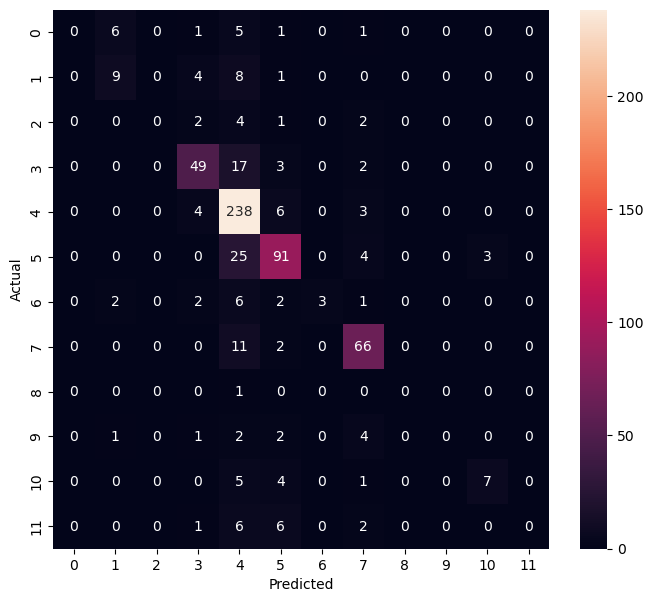

In [51]:
# Evaluate model

## Accuracy
accuracy_tfidf = round(accuracy_score(y_test, y_pred), 4)
print(f'The accuracy using TF-IDF is: {accuracy_tfidf*100:0.2f}%')

## Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Classification using Doc2Vec and Logistic Regression

We now try to do the same exercise, but using [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html). While Word2Vec computes a feature vector for every word in the corpus, Doc2Vec computes a feature vector for every document (i.e., sentence) in the corpus.

We first tokenize our data, using the same tokenizer as before. We use `TaggedDocument` from Gensim to obtain the appropriate input document format for `Doc2Vec`. `TaggedDocument` returns, for each observation, a document containing *words* (i.e., a list of tokens) and the associated *tags* (our label).

In [52]:
%%time

# Tokenize data - same tokenizer function as before
sample_tagged = data.apply(lambda r: TaggedDocument(words=spacy_tokenizer(r['Consumer complaint narrative']), tags=[r.Product]), axis=1)
print(sample_tagged.head(20))

0     ([2019, company, charge, credit, card, 230.00,...
1     ([report, single, late, payment, 7, year, old,...
2     ([dispute, follow, account, 1, 4.00, 2, 0.00, ...
3     ([i, dispute, follow, item, credit, report, bu...
4     ([response, citi, cards, clear, lot, confusion...
5     ([concern, contact, today, try, payment, mortg...
6     ([write, letter, file, complaint, begin, recei...
7     ([2016, purchase, truck, tell, finance, manage...
8     ([employer, submit, background, check, receive...
9     ([authorize, hard, credit, pull, credit, autho...
10    ([rushcard, access, fund, account, negative, b...
11    ([old, closed, account, remove, old, voluntary...
12    ([executive, offices, department, credit, card...
13    ([2, hard, inquiries, cbna, apply, card, suspe...
14    ([hard, inquiry, submit, credit, report, barcl...
15    ([request, credit, report, notice, account, re...
16    ([yes, send, letter, state, want, verification...
17    ([capital, auto, finance, tx, copy, letter

In [53]:
sample_tagged.values[10]

TaggedDocument(words=['rushcard', 'access', 'fund', 'account', 'negative', 'balance', 'week', 'customer', 'service', 'hang', 'numerous', 'time', 'hold', 'hr', 'time', 've', 'finally', 'tell', 'idea', 'money', 've', 'file', 'email', 'complaint', 'receive', 'different', 'ticket', 'number', "''", 'respond', 'week', 'basically', 'm', 'answer'], tags=['Credit card or prepaid card'])

Next, we split our dataset into training and test, using the same split as before.

In [54]:
# Train test split - same split as before
train_tagged, test_tagged = train_test_split(sample_tagged, test_size=0.2, random_state=1234)

To speed up the training process, we use the `multiprocessing` library ([Documentation](https://docs.python.org/3/library/multiprocessing.html)). It will allow to train the model using several worker threads via the parameter `workers` of `Doc2Vec`.

In [55]:
# Number of CPUs in the system
cores = multiprocessing.cpu_count()

Next we define the `Doc2Vec` model, using as parameters:
- `dm`: training algorithm, if 1 distributed memory is used (PV-DM), else distributed bag of words (PV-DBOW)
- `vector_size`: dimension of feature vector
- `hs`: if 1, hierarchical softmax will be used for model training; if set to 0, and negative is non-zero, negative sampling will be used
- `negative`: specifies how many "noise words" should be drawn for negative sampling
- `min_count`: ignore words with frequency lower than this
- `epochs`: number of iteration (epoch) over the corpus

In addition, we build our vocabulary.

In [56]:
# Define Doc2Vec and build vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=30, negative=6, hs=0, min_count=1, sample=0, workers=cores, epochs=300)
model_dbow.build_vocab([x for x in train_tagged.values])

We now train the distributed bag of words model. In short, it trains a neural network and the optimal weights are the coefficients of the vectors of the documents. Therefore, similar documents will be close to each other in the N-dimentional space (N being the size of the vectors). More information on this [here](https://thinkinfi.com/simple-doc2vec-explained/).

In [57]:
# Train distributed Bag of Word model
model_dbow.train(train_tagged, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

Next, we convert our tagged documents into vectors using the model we trained. We define a function that use as input our model and tagged documents and returns the targets (i.e., labels) and regressors, i.e., the vector representation of the complaints. We then apply this function to prepare the training and test set for the classification.

In [58]:
# Embedding
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=100)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

Note that each document (i.e., complaint) is now a vector in the space of 30 dimentions. Similar complaints should have similar vector representation.

In [59]:
X_train[:3]

(array([ 0.132618  ,  0.04208256, -0.5021517 ,  0.33614376,  0.07931963,
         0.21560343, -0.94405454, -0.6679139 , -1.5433534 ,  0.15584125,
        -0.7193605 ,  0.56718403,  0.04773099,  0.13492684, -0.40510452,
        -0.9872775 ,  0.18949753, -0.370363  ,  0.1187271 , -0.23082379,
        -1.1938246 ,  0.5837017 , -1.2132509 , -0.0814781 , -0.41362607,
        -0.30256683, -1.2729836 , -0.05234698, -0.48016146,  0.4692039 ],
       dtype=float32),
 array([-0.02096007,  0.13285364, -0.9088828 ,  0.9498269 , -0.2511467 ,
        -0.04609252, -0.87175596, -0.6145228 , -0.16000639, -0.34473404,
        -0.05370425,  0.37960777, -0.27225518, -0.32593548,  0.35407546,
        -0.47326937,  0.52649045,  0.32408002, -0.00142372, -0.41524735,
        -1.170233  ,  0.15983061, -0.8288015 , -0.61246634, -0.12932406,
        -0.25460905, -0.6120287 , -0.2662064 ,  1.2123199 , -0.28470767],
       dtype=float32),
 array([ 0.03409297, -0.2801329 , -0.8952417 , -0.82633144,  0.45045635,
   

Ok, we can finally implement our logistic regression. We proceed as before, training the model, predicting on the test set, and evaluating the performance of our classifier.

In [60]:
# Fit model on training set - same algorithm as before
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)

# Predictions
y_pred = logreg.predict(X_test)

The accuracy using TF-IDF is: 68.15%


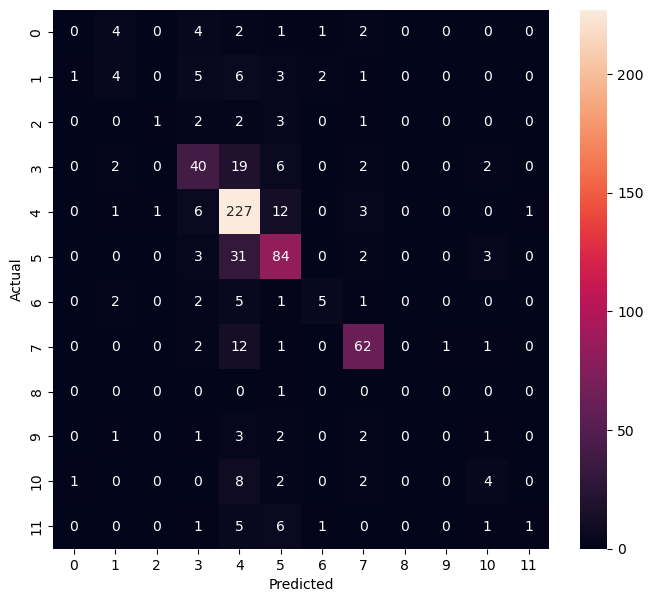

In [61]:
# Evaluate model

## Accuracy
accuracy_doc2vec = round(accuracy_score(y_test, y_pred), 4)
print(f'The accuracy using TF-IDF is: {accuracy_doc2vec*100:0.2f}%')

## Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

What do you observe?

### How to improve the accuracy of a text classifier?

In order to improve the prediction, we can try to:
- Resample our data (i.e., create balanced dataset)
- Tune the hyperparameters of the model
- Improve text preparation
- Use another classifier, e.g., k-NN, decision trees, random forests, etc.
- All of the above!

## Further reading

Text Analytics is a rich field. We have seen above one application of text classification. A common application of text classification is [Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis), which is the process of tagging data according to their sentiment, such as positive, negative and neutral. You can find a guide to sentiment analysis [here](https://huggingface.co/blog/sentiment-analysis-python). You can also find many already trained models on [Huggingface](https://huggingface.co/models), including ready-made classifier for sentiment analysis.

Finally, here are some resources on Word2Vec, GloVe, BERT to deepen your understanding of the topic:
- Rong, X. (2014). word2vec parameter learning explained. *arXiv preprint arXiv:*[1411.2738](https://arxiv.org/abs/1411.2738)
- [Introduction to Word Embedding and Word2Vec](https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa)
- [Word Embeddings for NLP](https://towardsdatascience.com/word-embeddings-for-nlp-5b72991e01d4)
- [NLP — Word Embedding & GloVe](https://jonathan-hui.medium.com/nlp-word-embedding-glove-5e7f523999f6)
- [Intuitive Guide to Understanding GloVe Embeddings](https://towardsdatascience.com/light-on-math-ml-intuitive-guide-to-understanding-glove-embeddings-b13b4f19c010)
- [Word2vec vs BERT](https://medium.com/@ankiit/word2vec-vs-bert-d04ab3ade4c9)
- [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794)